This Notebook was inspired by [Sasank Chilamkurthy's](https://chsasank.github.io) tutorial on how to train a convolutional neural network for image classification using transfer learning: [cs231n notes](https://cs231n.github.io/transfer-learning/).

In [ ]:
%matplotlib inline

In [ ]:
# License: BSD
# Authored by Sasank Chilamkurthy, modified for our project's training purposes 
# by Joao Pedro Zanlorensi

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image, ImageDraw
import math
import shutil
import json

cudnn.benchmark = True
plt.ion()   # interactive mode

## Extract and Prepare the Data

We will use torchvision and torch.utils.data packages for loading the
data.

In [ ]:
! wget https://zcart-product-recognizer-data.s3.sa-east-1.amazonaws.com/raw_image_data.zip
! unzip ./raw_image_data.zip
! rm ./raw_image_data.zip

In [ ]:
RAW_DATA_PATH = './raw_image_data/'
LABELS = {
    'post_it': {'id': 0, 'pictures': {}, 'total_pictures': 0}, 
    'guarana_soda': {'id': 1, 'pictures': {}, 'total_pictures': 0},
    'coke_soda': {'id': 2, 'pictures': {}, 'total_pictures': 0},
    'card_deck': {'id': 3, 'pictures': {}, 'total_pictures': 0},
    'blue_pens': {'id': 4, 'pictures': {}, 'total_pictures': 0}
}
AMT_CLASSES = len(LABELS)

In [ ]:
import json
bounding_boxes = json.load(open(RAW_DATA_PATH + 'bounding_boxes.labels'))
print(json.dumps(bounding_boxes, indent=2)[0:600])

{
  "version": 1,
  "type": "bounding-box-labels",
  "boundingBoxes": {
    "unknown.39n097ne.ingestion-645f8b4d4f-p2vmk.jpg": [
      {
        "label": "guarana_soda",
        "x": 120,
        "y": 265,
        "width": 172,
        "height": 207
      },
      {
        "label": "coke_soda",
        "x": 285,
        "y": 120,
        "width": 136,
        "height": 247
      },
      {
        "label": "post_it",
        "x": 162,
        "y": 149,
        "width": 158,
        "height": 128
      },
      {
        "label": "card_deck",
        "x": 0,
        "y": 14,
        "width": 1


In [ ]:
total_images = len(bounding_boxes['boundingBoxes'])

In [ ]:
# Flipping the bounding_boxes dictionary as so as we know in which file each label can be seen more easily
for image in bounding_boxes["boundingBoxes"]:
  for obj in bounding_boxes["boundingBoxes"][image]:
    LABELS[obj['label']]['pictures'][RAW_DATA_PATH + image] = \
        {
            'x': obj['x'], 
            'y': obj['y'], 
            'width': obj['width'], 
            'height': obj['height']
         }
    LABELS[obj['label']]['total_pictures'] += 1

In [ ]:
print('Total pictures for each class:')
for label in LABELS:
  print(label + ', ' + str(LABELS[label]['total_pictures']))

Total pictures for each class:
post_it, 273
guarana_soda, 283
coke_soda, 276
card_deck, 306
blue_pens, 293


In [ ]:
# Create a folder structure for training
if not os.path.exists('data'):
    for split in ['train', 'val']:
      for label in LABELS:
        os.makedirs(f'data/{split}/{label}')

In [ ]:
def split_dataset(class_name, image_names, train_size, val_size):
  for i, impage_path_and_name in enumerate(image_names):
        # Split into train, val and test
        if i <= train_size:
            split = 'train'
        else:
            split = 'val'
        
        source_image_path = impage_path_and_name
        target_image_folder = f'data/{split}/{class_name}'
        shutil.copy(source_image_path, target_image_folder)

In [ ]:
train_pct = 70

for label in LABELS:
  split_dataset(
      class_name  = label, 
      image_names = list(LABELS[label]['pictures'].keys()),
      train_size  = math.ceil(LABELS[label]['total_pictures'] * train_pct/100),
      val_size    = LABELS[label]['total_pictures'] - math.ceil(LABELS[label]['total_pictures'] * train_pct/100)
  )

In [ ]:
mean_imagenet = [0.485, 0.456, 0.406]
std_imagenet = [0.229, 0.224, 0.225]

**Note:** these Normalization parameters are the mean and standard deviation RGB values from the tensors built out of the images that are a part of [ImageNet](https://www.image-net.org/).  
A reference for calculating the mean and standard deviation values for custom datasets can be found [here](https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/).
We'll go straight with he ImageNet values, but if needed we can try out the custom values for fine tuning.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_imagenet,std_imagenet)
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_imagenet,std_imagenet)
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



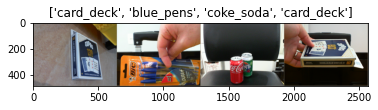

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean_imagenet)
    std = np.array(std_imagenet)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, AMT_CLASSES)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=200)

Epoch 0/199
----------
train Loss: 0.9023 Acc: 0.5935
val Loss: 0.1195 Acc: 0.9547

Epoch 1/199
----------
train Loss: 0.8842 Acc: 0.5935
val Loss: 0.1189 Acc: 0.9597

Epoch 2/199
----------
train Loss: 0.8902 Acc: 0.5846
val Loss: 0.1193 Acc: 0.9572

Epoch 3/199
----------
train Loss: 0.8746 Acc: 0.6113
val Loss: 0.1060 Acc: 0.9597

Epoch 4/199
----------
train Loss: 0.8611 Acc: 0.6162
val Loss: 0.1046 Acc: 0.9673

Epoch 5/199
----------
train Loss: 0.9178 Acc: 0.5836
val Loss: 0.1100 Acc: 0.9647

Epoch 6/199
----------
train Loss: 0.8810 Acc: 0.5994
val Loss: 0.1196 Acc: 0.9622

Epoch 7/199
----------
train Loss: 0.8698 Acc: 0.6182
val Loss: 0.1159 Acc: 0.9572

Epoch 8/199
----------
train Loss: 0.8764 Acc: 0.5865
val Loss: 0.1142 Acc: 0.9622

Epoch 9/199
----------
train Loss: 0.8651 Acc: 0.6014
val Loss: 0.1093 Acc: 0.9597

Epoch 10/199
----------
train Loss: 0.8840 Acc: 0.6073
val Loss: 0.1294 Acc: 0.9647

Epoch 11/199
----------
train Loss: 0.8906 Acc: 0.5826
val Loss: 0.1201 Acc

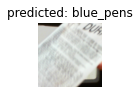

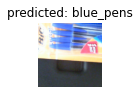

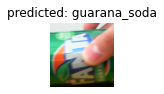

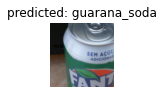

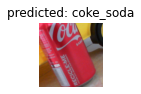

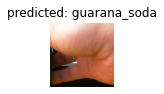

In [ ]:
visualize_model(model_ft)

In [ ]:
model_scripted = torch.jit.script(model_ft) # Export to TorchScript
model_scripted.save('model_ft_scripted.pt') # Save

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, AMT_CLASSES)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=200)

Epoch 0/199
----------
train Loss: 1.6838 Acc: 0.2750
val Loss: 0.9615 Acc: 0.6373

Epoch 1/199
----------
train Loss: 1.4508 Acc: 0.3828
val Loss: 1.5230 Acc: 0.6071

Epoch 2/199
----------
train Loss: 1.4264 Acc: 0.4352
val Loss: 0.4770 Acc: 0.8413

Epoch 3/199
----------
train Loss: 1.3521 Acc: 0.4679
val Loss: 0.4877 Acc: 0.8287

Epoch 4/199
----------
train Loss: 1.3800 Acc: 0.4560
val Loss: 0.6501 Acc: 0.7708

Epoch 5/199
----------
train Loss: 1.2038 Acc: 0.5074
val Loss: 0.5005 Acc: 0.8413

Epoch 6/199
----------
train Loss: 1.2742 Acc: 0.4876
val Loss: 0.6364 Acc: 0.7884

Epoch 7/199
----------
train Loss: 1.1407 Acc: 0.5341
val Loss: 0.4289 Acc: 0.8615

Epoch 8/199
----------
train Loss: 1.0938 Acc: 0.5361
val Loss: 0.3507 Acc: 0.8841

Epoch 9/199
----------
train Loss: 1.0834 Acc: 0.5757
val Loss: 0.3351 Acc: 0.8866

Epoch 10/199
----------
train Loss: 1.1112 Acc: 0.5440
val Loss: 0.3675 Acc: 0.8741

Epoch 11/199
----------
train Loss: 1.0723 Acc: 0.5420
val Loss: 0.3845 Acc

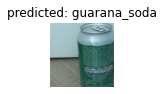

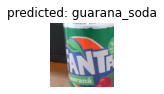

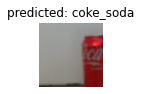

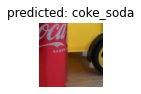

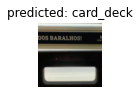

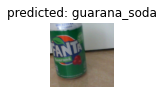

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
model_scripted = torch.jit.script(model_conv) # Export to TorchScript
model_scripted.save('model_conv_scripted.pt') # Save

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp ./model_conv_scripted.pt ./drive/MyDrive/TCC
! cp ./model_ft_scripted.pt ./drive/MyDrive/TCC